load datasets

In [1]:
import os
ROOT_DIR = os.getcwd()
BUOY_DIR = os.path.join(ROOT_DIR, "buoy_data")
input_dir = os.path.join(BUOY_DIR, "Train/img")
target_dir = os.path.join(BUOY_DIR, "Train/masks_machine")

**Prepare paths of input images and target segmentation masks**

In [2]:

# Here We make the only change required by the assignment
# previous image size values were (128,128) 
# however the assignment requested we reform the U-Net architecture
# to handle an 80x80 image. Additionally, we must resize the images and mask
# to similar dimensions. The variable below, img_size is used to 
# define the size in the U-Net Architecture, image size, and mask size. 
img_size = (80, 80)
print("Image size is {}, was {}".format((80,80),(128,128)))
print("U-Net Architecture accepts 80,80,3")
num_classes = 1
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Image size is (80, 80), was (128, 128)
U-Net Architecture accepts 80,80,3
Number of samples: 19695
c:\CV-Proj\buoy_data\Train/img\013084e118.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118.png
c:\CV-Proj\buoy_data\Train/img\013084e118_0D9YFTczAO.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118_0D9YFTczAO.png
c:\CV-Proj\buoy_data\Train/img\013084e118_0HGb6P4UZp.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118_0HGb6P4UZp.png
c:\CV-Proj\buoy_data\Train/img\013084e118_0XjirAwfTp.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118_0XjirAwfTp.png
c:\CV-Proj\buoy_data\Train/img\013084e118_0bsosypzLj.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118_0bsosypzLj.png
c:\CV-Proj\buoy_data\Train/img\013084e118_0eDFi1MlVS.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118_0eDFi1MlVS.png
c:\CV-Proj\buoy_data\Train/img\013084e118_1OsuNP4E8I.jpg | c:\CV-Proj\buoy_data\Train/masks_machine\013084e118_1OsuNP4E8I.png
c:\CV-Proj\buoy_data\Train/img\013084e118

**Display an input image and a segmentation mask**

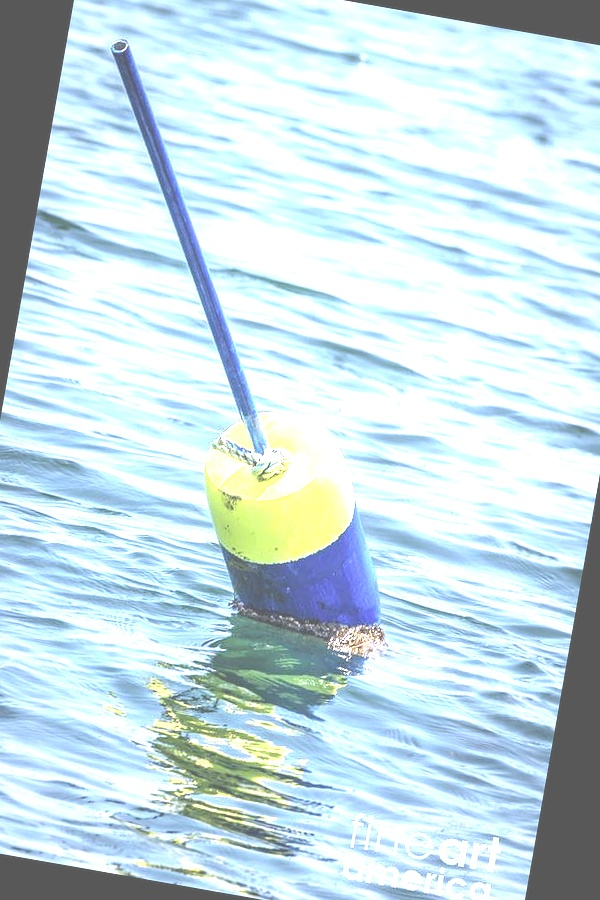

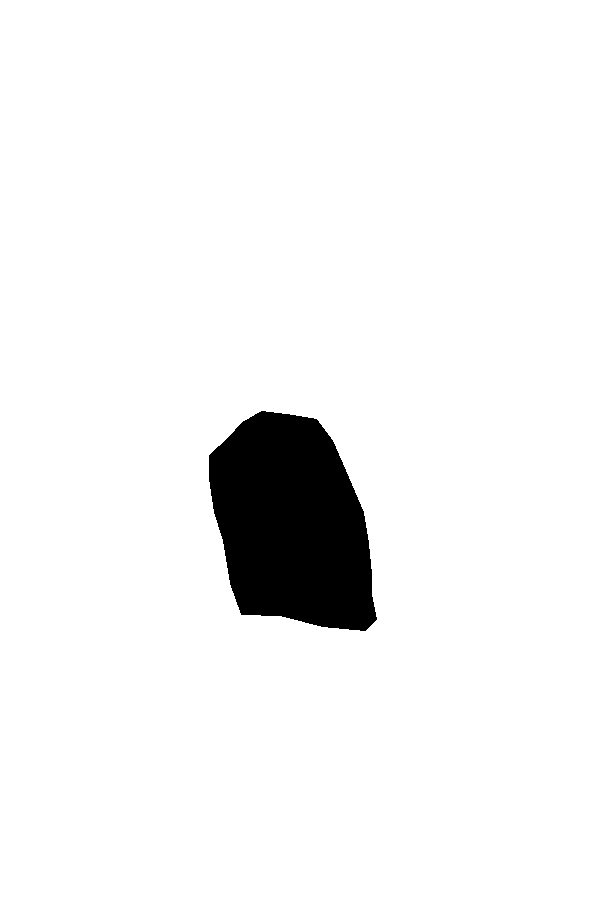

[1 2]


In [3]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import numpy as np


# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)
print(np.unique(load_img(target_img_paths[9])))

**Prepare Sequence class to load & vectorize batches of data**

In [4]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class Buoys(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

**U-Net blocks**

In [5]:
def down_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

**U-Net architecture**

In [12]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_size[0], img_size[1], 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) #128 -> 64
    c2, p2 = down_block(p1, f[1]) #64 -> 32
    c3, p3 = down_block(p2, f[2]) #32 -> 16
    c4, p4 = down_block(p3, f[3]) #16->8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    #outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    outputs = keras.layers.Conv2D(4, (1, 1), padding="same", activation="softmax")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

In [7]:
model = UNet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80, 80, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 16)   2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 40, 16)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

**Set aside a validation split**

In [13]:
import random
# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = Buoys(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = Buoys(batch_size, img_size, val_input_img_paths, val_target_img_paths)

**Train the model**

In [14]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("buoy_detection.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 1
history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

584/584 [==============================] - 389s 664ms/step - loss: 0.4012 - val_loss: 0.1236


**Visualize predictions**

In [17]:
# Generate predictions for all images in the validation set

val_gen = Buoys(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


In [ ]:
for i in range(len(val_preds)):
    display_mask(i)